<a href="https://colab.research.google.com/github/vladimiralencar/DeepLearning-LANA/blob/master/DoencasDePele/Skin_Cancer_CNN_Model_CopiaGoogleDriveParaColab_v50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making A **CNN** Model !
On that kernal we built a cnn model and train it on skin-cancer dataset.
![CNN ’odel Architectural](https://image.ibb.co/n8PBkL/cover.png)

Start with importing libraries help us !

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import keras
from keras.utils.np_utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Nontar arquivos do google drive

In [38]:
# montar arquivos do google drive
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [39]:
#!ls Dataset-Cancer-de-Pele-2019

!ls drive/'My Drive'/datasets/DoencasDePele-2019/skin-cancer-mnist-ham10000

folder = "drive/My Drive/datasets/DoencasDePele-2019/skin-cancer-mnist-ham10000"
folder = "skin-cancer-mnist-ham10000"

category_samples.png	     hmnist_28_28_RGB.csv
dataset-doencas-de-pele.zip  hmnist_8_8_L.csv
HAM10000_images_part_1	     hmnist_8_8_RGB.csv
HAM10000_images_part_2	     model.h5
HAM10000_metadata.csv	     Skin_Cancer_CNN_Model_93_acc_TITAN.ipynb
hmnist_28_28_L.csv	     tile_df.csv


In [40]:
%%time
!cp drive/'My Drive'/datasets/DoencasDePele-2019/skin-cancer-mnist-ham10000/*.zip .
!ls

category_samples.png	     drive	  skin-cancer-mnist-ham10000
dataset-doencas-de-pele.zip  sample_data
CPU times: user 138 ms, sys: 115 ms, total: 253 ms
Wall time: 19.2 s


In [41]:
%%time
!unzip dataset-doencas-de-pele.zip
!ls

Archive:  dataset-doencas-de-pele.zip
  inflating: skin-cancer-mnist-ham10000/_DS_Store  
replace skin-cancer-mnist-ham10000/category_samples.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: skin-cancer-mnist-ham10000/category_samples.png  
  inflating: skin-cancer-mnist-ham10000/Skin_Cancer_CNN_Model_93_acc_TITAN.ipynb  
  inflating: skin-cancer-mnist-ham10000/HAM10000_metadata.csv  
  inflating: skin-cancer-mnist-ham10000/tile_df.csv  
  inflating: skin-cancer-mnist-ham10000/hmnist_8_8_L.csv  
  inflating: skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027326.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024834.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024820.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026945.jpg  
  inflating: skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026789.jpg  
  inflating: skin-c

make the image path dictionary by joining the folder path from base directory `base_skin_dir` and merge the images in jpg format from both the folders `HAM10000_images_part1.zip` and `HAM10000_images_part2.zip`

In [42]:
#!ls skin-cancer-mnist-ham10000/HAM10000_images_part_2
!rm skin-cancer-mnist-ham10000/_DS_Store
!ls -ila skin-cancer-mnist-ham10000

total 225244
10354848 drwxr-xr-x 5 root root     4096 Oct 23 07:24 .
14286854 drwxr-xr-x 1 root root     4096 Oct 23 07:23 ..
10354850 -rw-r--r-- 1 root root  1265007 Oct 22 11:15 category_samples.png
10354856 drwxr-xr-x 2 root root   139264 Oct 23 07:24 HAM10000_images_part_1
10354880 drwxr-xr-x 2 root root   126976 Oct 23 07:24 HAM10000_images_part_2
10354852 -rw-r--r-- 1 root root   563277 Oct 21 15:16 HAM10000_metadata.csv
10354896 -rw-r--r-- 1 root root 30807979 Oct 21 15:17 hmnist_28_28_L.csv
10355541 -rw-r--r-- 1 root root 91820383 Oct 21 15:18 hmnist_28_28_RGB.csv
10354854 -rw-r--r-- 1 root root  2537778 Oct 21 15:18 hmnist_8_8_L.csv
10354855 -rw-r--r-- 1 root root  7524968 Oct 21 15:18 hmnist_8_8_RGB.csv
10489261 drwxr-xr-x 4 root root   266240 Oct 23 03:05 images
10355065 -rw-r--r-- 1 root root 86729528 Oct 22 11:15 model.h5
10354851 -rw-r--r-- 1 root root  1127062 Oct 22 11:14 Skin_Cancer_CNN_Model_93_acc_TITAN.ipynb
10354853 -rw-r--r-- 1 root root  7699317 Oct 22 11:15 tile

In [43]:
#!mkdir skin-cancer-mnist-ham10000/images
!cp -r skin-cancer-mnist-ham10000/HAM10000_images_part_1/*.* skin-cancer-mnist-ham10000/images
!cp -r skin-cancer-mnist-ham10000/HAM10000_images_part_2/*.* skin-cancer-mnist-ham10000/images
!ls skin-cancer-mnist-ham10000/images

 HAM10000_images_part_1   ISIC_0027357.jpg	 ISIC_0030624.jpg
 HAM10000_images_part_2   ISIC_0027358.jpg	 ISIC_0030625.jpg
 ISIC_0024306.jpg	  ISIC_0027359.jpg	 ISIC_0030626.jpg
 ISIC_0024307.jpg	  ISIC_0027360.jpg	 ISIC_0030627.jpg
 ISIC_0024308.jpg	  ISIC_0027361.jpg	 ISIC_0030628.jpg
 ISIC_0024309.jpg	  ISIC_0027363.jpg	 ISIC_0030630.jpg
 ISIC_0024310.jpg	  ISIC_0027364.jpg	 ISIC_0030631.jpg
 ISIC_0024311.jpg	  ISIC_0027366.jpg	 ISIC_0030633.jpg
 ISIC_0024312.jpg	  ISIC_0027367.jpg	 ISIC_0030635.jpg
 ISIC_0024313.jpg	  ISIC_0027368.jpg	 ISIC_0030636.jpg
 ISIC_0024314.jpg	  ISIC_0027369.jpg	 ISIC_0030637.jpg
 ISIC_0024315.jpg	  ISIC_0027370.jpg	 ISIC_0030638.jpg
 ISIC_0024316.jpg	  ISIC_0027371.jpg	 ISIC_0030639.jpg
 ISIC_0024317.jpg	  ISIC_0027372.jpg	 ISIC_0030649.jpg
 ISIC_0024318.jpg	  ISIC_0027374.jpg	 ISIC_0030658.jpg
 ISIC_0024319.jpg	  ISIC_0027375.jpg	 ISIC_0030659.jpg
 ISIC_0024320.jpg	  ISIC_0027376.jpg	 ISIC_0030660.jpg
 ISIC_0024321.jpg	  ISIC_0027378.jpg	 ISIC_0030661.jp

In [44]:
!ls skin-cancer-mnist-ham10000/images | wc -l

7310


In [45]:
!ls skin-cancer-mnist-ham10000/HAM10000_images_part_2/ | wc -l

3307


In [46]:
!ls skin-cancer-mnist-ham10000/HAM10000_images_part_1/ | wc -l

4001


In [47]:
folder

'skin-cancer-mnist-ham10000'

In [0]:
folder = "skin-cancer-mnist-ham10000/images"

In [49]:
%%time
#base_skin_dir = os.path.join('.', folder)
base_skin_dir = folder
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

CPU times: user 35.8 ms, sys: 8.92 ms, total: 44.8 ms
Wall time: 44.7 ms


In [50]:
skin_dir = "skin-cancer-mnist-ham10000"
tile_df = pd.read_csv(os.path.join(skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9160,HAM_0006616,ISIC_0031794,nv,histo,85.0,male,upper extremity,skin-cancer-mnist-ham10000/images/HAM10000_ima...,Melanocytic nevi,4
1496,HAM_0000483,ISIC_0033643,mel,histo,70.0,male,lower extremity,skin-cancer-mnist-ham10000/images/HAM10000_ima...,Melanoma,5
6547,HAM_0002029,ISIC_0030270,nv,follow_up,50.0,male,abdomen,skin-cancer-mnist-ham10000/images/HAM10000_ima...,Melanocytic nevi,4


## Cleaning Data !!
first thing showing if there is a `null` data.

In [51]:
len(tile_df)

10015

In [52]:
tile_df.isnull().sum()

lesion_id           0
image_id            0
dx                  0
dx_type             0
age                57
sex                 0
localization        0
path             2720
cell_type           0
cell_type_idx       0
dtype: int64

In [0]:
tile_df2 = tile_df.dropna()
len(tile_df2)
tile_df = tile_df2.copy()

Fill the null values by their mean.

In [0]:
tile_df['age'].fillna((tile_df['age'].mean()), inplace=True)

insure that now we have no empety data.

In [55]:
tile_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [56]:
import sys
print(sys.version)

3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


## Loading and resize images !!
we resized the images to 100 * 75 whitch tensorflow can handle.

In [57]:
%%time
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

CPU times: user 1min 4s, sys: 1.65 s, total: 1min 6s
Wall time: 1min 17s


Show some image samples...

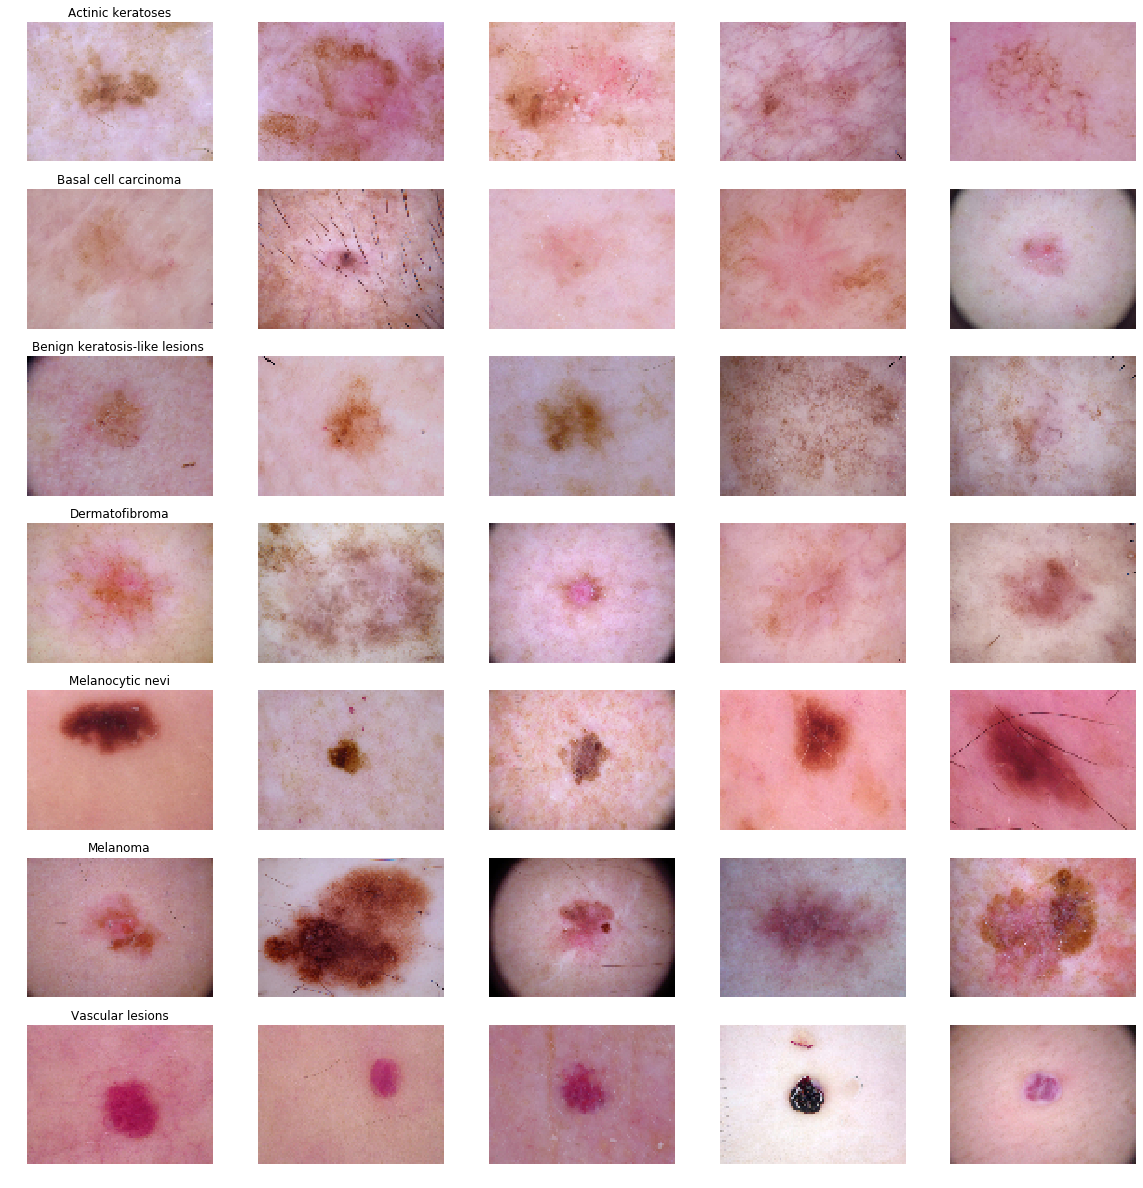

In [58]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        str_image = c_row['image']
        #image1 = (np.float_(str_image))
        image1 = np.asarray(str_image, dtype=np.float64, order='C')
        #image1 = np.array(str_image)
        #print(type(image1))
        #print(image1)
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [59]:
# Checking the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    7255
Name: image, dtype: int64

## Train Test Split !!
splitting data into train and test with 20:80 ratio.

In [60]:
%%time
features=tile_df.drop(columns=['cell_type_idx'],axis=1)
target=tile_df['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

CPU times: user 31.2 ms, sys: 42.4 ms, total: 73.7 ms
Wall time: 85.6 ms


## Normalization !!
subtract their mean values from it and then dividing by their standard deviation.

In [61]:
%%time
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

CPU times: user 2.14 s, sys: 132 ms, total: 2.27 s
Wall time: 2.36 s


## Label Encoding !!
Labels are 7 different classes of cell types from 0 to 6. We need to encode these lables to one hot vectors.

In [0]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

## Training and Validation Split !!
validate:train >> 10:90 %

In [63]:
%%time
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

CPU times: user 246 ms, sys: 1.5 s, total: 1.75 s
Wall time: 1.77 s


In [64]:
%%time
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 26.2 µs


## Model Building !!

In [65]:
input_shape = (75, 100, 3)
num_classes = 7
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.55),
    Dense(7, activation='softmax')
])

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 25, 64)       

**Data Augmentation** to avoiding the overfitting.

In [69]:
%%time
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

CPU times: user 321 ms, sys: 9.51 ms, total: 330 ms
Wall time: 337 ms


## Fitting The model !!

In [70]:
%%time
epochs = 50 
batch_size = 10
history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    #,callbacks=[learning_rate_reduction]
)

Epoch 1/50
522/522 [==============================] - 18s 35ms/step - loss: 0.2353 - acc: 0.9102 - val_loss: 0.2226 - val_acc: 0.9191
Epoch 2/50
522/522 [==============================] - 17s 33ms/step - loss: 0.2142 - acc: 0.9154 - val_loss: 0.2077 - val_acc: 0.9198
Epoch 3/50
522/522 [==============================] - 17s 33ms/step - loss: 0.2080 - acc: 0.9180 - val_loss: 0.1938 - val_acc: 0.9230
Epoch 4/50
522/522 [==============================] - 17s 33ms/step - loss: 0.2034 - acc: 0.9202 - val_loss: 0.1950 - val_acc: 0.9235
Epoch 5/50
522/522 [==============================] - 17s 33ms/step - loss: 0.2010 - acc: 0.9221 - val_loss: 0.2060 - val_acc: 0.9191
Epoch 6/50
522/522 [==============================] - 17s 33ms/step - loss: 0.1977 - acc: 0.9217 - val_loss: 0.2069 - val_acc: 0.9216
Epoch 7/50
522/522 [==============================] - 18s 34ms/step - loss: 0.1946 - acc: 0.9227 - val_loss: 0.1829 - val_acc: 0.9294
Epoch 8/50
522/522 [==============================] - 17s 33ms

## Model Evaluation !!

In [71]:
%%time
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

581/581 [==============================] - 0s 790us/sample - loss: 0.1690 - acc: 0.9341
Validation: accuracy = 0.934104  ;  loss_v = 0.168954
Test: accuracy = 0.928325  ;  loss = 0.180813
CPU times: user 1.17 s, sys: 357 ms, total: 1.53 s
Wall time: 2.32 s


In [0]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

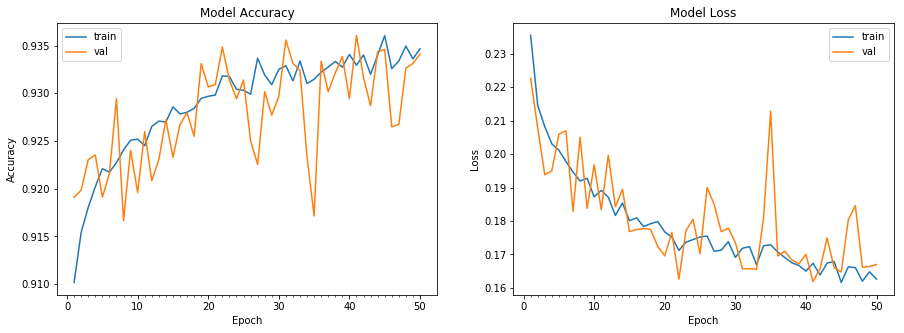

CPU times: user 822 ms, sys: 351 ms, total: 1.17 s
Wall time: 803 ms


In [73]:
%%time
plot_model_history(history)